# Ударжание/отток клиентов телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Коротко об операторе

Оператор предоставляет два основных типа услуг:
1.	Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2.	Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
-	Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
-	Выделенная линия технической поддержки (TechSupport);
-	Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
-	Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Информация о договорах актуальна на 1 февраля 2020.

# Исследовательский анализ данных

## Подгрузка данных + первичный анализ

In [241]:
#!pip install library -U --user
#!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [242]:
import pandas as pd
import numpy as np
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)

# model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

In [243]:
try:
    contract = pd.read_csv("d:/Temp/final_provider/contract.csv") #информация о договоре
    personal_data = pd.read_csv("d:/Temp/final_provider/personal.csv") #персональные данные клиента
    internet = pd.read_csv("d:/Temp/final_provider/internet.csv") #информация об интернет-услугах
    phone = pd.read_csv("d:/Temp/final_provider/phone.csv") #информация об услугах телефонии.
    
except FileNotFoundError:
    contract = pd.read_csv("/datasets/final_provider/contract.csv") #информация о договоре
    personal_data = pd.read_csv("/datasets/final_provider/personal.csv") #персональные данные клиента
    internet = pd.read_csv("/datasets/final_provider/internet.csv") #информация об интернет-услугах
    phone = pd.read_csv("/datasets/final_provider/phone.csv") #информация об услугах телефонии.

### Договор

In [244]:
def inform(data, name):
    data.columns = [col.lower() for col in data.columns]
    
    print(name.center(100, ' '), '\n')
    data.info()
    print('\n', 'Общий вид датасета'.center(100, ' '))
    display(data.sample(5))
    print('\n', 'Процентное количество пропусков в датасете'.center(100, ' '), '\n')
    print(data.isnull().mean())
    

In [245]:
inform(contract, 'Информация о договоре')

                                       Информация о договоре                                         

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerid          7043 non-null object
begindate           7043 non-null object
enddate             7043 non-null object
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

                                          Общий вид датасета                                         


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
3496,5201-FRKKS,2018-01-01,No,Month-to-month,No,Bank transfer (automatic),74.30,1952.25
6393,3466-RITXD,2017-12-01,No,Month-to-month,Yes,Credit card (automatic),92.40,2349.8
6931,2371-KFUOG,2015-04-01,No,One year,No,Bank transfer (automatic),99.15,5720.95
2887,5696-QURRL,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Mailed check,45.05,45.05
4795,6532-YLWSI,2015-06-01,2019-11-01 00:00:00,One year,No,Bank transfer (automatic),20.80,1021.8



                              Процентное количество пропусков в датасете                              

customerid          0.0
begindate           0.0
enddate             0.0
type                0.0
paperlessbilling    0.0
paymentmethod       0.0
monthlycharges      0.0
totalcharges        0.0
dtype: float64


Приведем столбцы к нужному типу: 
 - begindate к datetime
 - totalcharges к float
 
Создадим из enddate - бинарный target и признак life_time на 01-02-2020 - время жизни клиента.

paymentmethod - уйдем от object, переведем в int как авансовый период: 1, 12 или 24 месяца.

#### Преобразования

In [246]:
contract['begindate'] = pd.to_datetime(contract['begindate'])

In [247]:
contract['begindate'].describe()

count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: begindate, dtype: object

В нашей базе заключение договоров началось с октября 2013, в нашем распоряжении перемещенеие клиентов более чем за 6 лет.

Имеются записи о том что договор заключен 1 февраля 2020, узнаем сколько было заключено договоров в эту дату.

In [248]:
display(contract[contract['begindate'] == '2020-02-01'])
print('Количество договоров заключенных 2020-02-01 -', len(contract[contract['begindate'] == '2020-02-01']))

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Количество договоров заключенных 2020-02-01 - 11


In [249]:
len(contract[contract['totalcharges'] == ' '])

11

Общее количество записей с пустой выручкой тоже 11. Удалим данные записи, т.к информационной нагрузки они не несут. И преобразуем тип столбца totalcharges к float.

In [250]:
contract = contract[contract['totalcharges'] != ' ']

In [251]:
contract['totalcharges'] = contract['totalcharges'].astype('float64')

Заменим в столбце дата расторжения No на 2020-02-01, для вычисления life_time.

In [252]:
contract['enddate'].replace('No', '2020-02-01', inplace=True)
contract['enddate'] = pd.to_datetime(contract['enddate'])

Т.к в базе хранятся даты только от 1 числа месяца, уберем излишки информации, оставим только месяц даты заключения и расторжения договора.

In [253]:
contract['month_begin'] = contract.apply(lambda row: row.begindate.month, axis=1) #месяц начала договора
contract['month_end'] = contract['enddate'].apply(lambda x: x.month) # месяц окончания договора, возможна сезонность
contract

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,month_begin,month_end
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,1,2
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,4,2
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,10,12
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,5,2
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,9,11
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,2,2
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,2,2
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,3,2
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,7,11


Создадим целевой признак, target и  признак life_time. Заменим месяц расторженных договоров на 0, для визуального удобства.

In [254]:
contract.loc[contract['enddate'] == '2020-02-01', 'target'] = 0
contract.loc[contract['enddate'] != '2020-02-01', 'target'] = 1
contract['target'] = contract['target'].astype('int')

contract['life_time'] = contract['enddate'] - contract['begindate']
contract['life_time'] = contract.apply(lambda row: row.life_time.days, axis=1)

contract.loc[contract['target'] == 0, 'month_end'] = 0 # заменим месяц нерасторженных договорв на 0

contract

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,month_begin,month_end,target,life_time
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,4,0,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,10,12,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,5,0,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,9,11,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,2,0,0,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,2,0,0,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,3,0,0,337
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,7,11,1,123


Изменим типы оплаты на количество месяц авансовой системы.

In [255]:
contract['type'].replace({'Two year': 24, 'One year':12, 'Month-to-month':1}, inplace=True)

Удалим лишние признаки: даты договора и расторжения - их заменили на месяц договора и расторжения, так же признаки указывающие на выставление счетов и способах оплаты, как не значимые.

In [256]:
contract = contract.drop(columns=['begindate', 'enddate', 'paperlessbilling', 'paymentmethod'])

In [257]:
contract

,customerid,type,monthlycharges,totalcharges,month_begin,month_end,target,life_time
0,7590-VHVEG,1,29.85,29.85,1,0,0,31
1,5575-GNVDE,12,56.95,1889.50,4,0,0,1036
2,3668-QPYBK,1,53.85,108.15,10,12,1,61
3,7795-CFOCW,12,42.30,1840.75,5,0,0,1371
4,9237-HQITU,1,70.70,151.65,9,11,1,61
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,12,84.80,1990.50,2,0,0,730
7039,2234-XADUH,12,103.20,7362.90,2,0,0,2191
7040,4801-JZAZL,1,29.60,346.45,3,0,0,337
7041,8361-LTMKD,1,74.40,306.60,7,11,1,123


Оценим корреляцию признаков итоговой таблицы contract

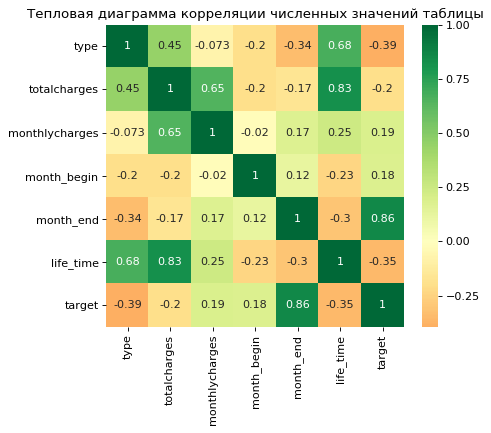

In [258]:
contract_col = contract[['type', 'totalcharges', 'monthlycharges', 'month_begin', 'month_end', 'life_time', 'target']]
plt.figure(figsize=(6,5), dpi= 80);
sns.heatmap(
    contract_col.corr(),
    xticklabels=contract_col.corr().columns,
    yticklabels=contract_col.corr().columns,
    cmap='RdYlGn', center=0, annot=True);
plt.title('Тепловая диаграмма корреляции численных значений таблицы');

Как видим из тепловой карты, месяц расторжения договора коррелирует с целевым признаком. В итоговой таблице данный признак month_end удалим, т.к фактически утечка информации.

Перейдем к следующей таблице.

### Персональные данные клиента

In [259]:
inform(personal_data, 'Персональные данные клиента')

                                    Персональные данные клиента                                      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerid       7043 non-null object
gender           7043 non-null object
seniorcitizen    7043 non-null int64
partner          7043 non-null object
dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

                                          Общий вид датасета                                         


,customerid,gender,seniorcitizen,partner,dependents
5079,2507-QZPQS,Male,0,No,No
2472,3200-MNQTF,Male,0,Yes,No
5271,6507-DTJZV,Male,0,No,Yes
6087,8319-QBEHW,Male,0,No,Yes
6902,5820-PTRYM,Female,1,Yes,No



                              Процентное количество пропусков в датасете                              

customerid       0.0
gender           0.0
seniorcitizen    0.0
partner          0.0
dependents       0.0
dtype: float64


In [260]:
for col in personal_data.columns:
    print(f'В столбце {col} уникальные значения - {personal_data[col].unique()}')

В столбце customerid уникальные значения - ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
В столбце gender уникальные значения - ['Female' 'Male']
В столбце seniorcitizen уникальные значения - [0 1]
В столбце partner уникальные значения - ['Yes' 'No']
В столбце dependents уникальные значения - ['No' 'Yes']


#### Вывод

В таблице нет пропусков, сначала внесем данные в итоговую таблицу, проведем анализ, и будем решать о целесообразности признаков.

### Интернет и телефония

Рассмотрим какие группы абонентов какими услугами пользуются

In [261]:
inform(phone, 'Информация об услугах телефонии')

                                  Информация об услугах телефонии                                    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerid       6361 non-null object
multiplelines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB

                                          Общий вид датасета                                         


,customerid,multiplelines
3690,0374-AACSZ,No
414,1480-BKXGA,Yes
716,3442-ZHHCC,Yes
5124,5510-BOIUJ,No
3041,0897-FEGMU,Yes



                              Процентное количество пропусков в датасете                              

customerid       0.0
multiplelines    0.0
dtype: float64


In [262]:
inform(internet, 'Информация об интернет-услугах')

                                   Информация об интернет-услугах                                    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerid          5517 non-null object
internetservice     5517 non-null object
onlinesecurity      5517 non-null object
onlinebackup        5517 non-null object
deviceprotection    5517 non-null object
techsupport         5517 non-null object
streamingtv         5517 non-null object
streamingmovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB

                                          Общий вид датасета                                         


,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
2774,1568-BEKZM,DSL,Yes,Yes,Yes,Yes,Yes,Yes
540,0214-JHPFW,DSL,No,Yes,Yes,Yes,Yes,Yes
2703,0436-TWFFZ,DSL,Yes,No,Yes,Yes,Yes,Yes
836,4026-SKKHW,DSL,No,No,No,Yes,No,No
551,8040-MNRTF,Fiber optic,No,No,No,No,No,No



                              Процентное количество пропусков в датасете                              

customerid          0.0
internetservice     0.0
onlinesecurity      0.0
onlinebackup        0.0
deviceprotection    0.0
techsupport         0.0
streamingtv         0.0
streamingmovies     0.0
dtype: float64


#### Абоненты пользующиеся интернетом и телефонией

Рассмотрим абонентов с разными потребностями поближе

In [263]:
data_full = phone.merge(internet, how='outer', on='customerid')
data_internet_phone = data_full[(data_full['multiplelines'].isnull() == False) & (data_full['internetservice'].isnull() == False)]
data_internet_phone.reset_index(drop=True, inplace=True)
data_internet_phone

,customerid,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
1,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
2,9237-HQITU,No,Fiber optic,No,No,No,No,No,No
3,9305-CDSKC,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
4,1452-KIOVK,Yes,Fiber optic,No,Yes,No,No,Yes,No
...,...,...,...,...,...,...,...,...,...
4830,8456-QDAVC,No,Fiber optic,No,No,No,No,Yes,No
4831,6840-RESVB,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
4832,2234-XADUH,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
4833,8361-LTMKD,Yes,Fiber optic,No,No,No,No,No,No


In [264]:
print('Общее количество пользователей', data_full.shape[0],
      '\nОбщее количество уникальных пользователей', len(data_full['customerid'].unique()))

Общее количество пользователей 7043 
Общее количество уникальных пользователей 7043


#### Абоненты с многоканальной телефонией

In [265]:
data_phone = data_full[(data_full['multiplelines'].isnull() == False) & (data_full['internetservice'].isnull() == True)]

In [266]:
data_phone = data_phone[['customerid', 'multiplelines']]
data_phone.reset_index(drop=True, inplace=True)
data_phone

,customerid,multiplelines
0,7469-LKBCI,No
1,8191-XWSZG,No
2,1680-VDCWW,No
3,1066-JKSGK,No
4,7310-EGVHZ,No
...,...,...
1521,4807-IZYOZ,No
1522,9710-NJERN,No
1523,9837-FWLCH,No
1524,0871-OPBXW,No


In [267]:
data_phone['multiplelines'].value_counts()

No     1184
Yes     342
Name: multiplelines, dtype: int64

#### Абоненты пользующиеся интернетом

In [268]:
data_internet = data_full[(data_full['multiplelines'].isnull() == True) & (data_full['internetservice'].isnull() == False)]

In [269]:
data_internet.reset_index(drop=True, inplace=True)
data_internet['multiplelines'] = 'No'
data_internet

,customerid,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,No,DSL,No,Yes,No,No,No,No
1,7795-CFOCW,No,DSL,Yes,No,Yes,Yes,No,No
2,6713-OKOMC,No,DSL,Yes,No,No,No,No,No
3,8779-QRDMV,No,DSL,No,No,Yes,No,No,Yes
4,8665-UTDHZ,No,DSL,No,Yes,No,No,No,No
...,...,...,...,...,...,...,...,...,...
677,4501-VCPFK,No,DSL,No,No,Yes,Yes,No,No
678,2274-XUATA,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes
679,2235-DWLJU,No,DSL,No,No,No,No,Yes,Yes
680,7750-EYXWZ,No,DSL,No,Yes,Yes,Yes,Yes,Yes


In [270]:
data_internet['internetservice'].value_counts()

DSL    682
Name: internetservice, dtype: int64

О телефонной связи: будем считать, что у всех абонентов с DSL услуга телефонии есть по умолчанию. А у абонентов с оптикой, у всех есть подключение одной или более линии связи. Т.е  все абоненты подключены к услугам голосовой связи.

Выделим признак факт наличия/отсутствия интернет услуги.

#### Обработка итоговой таблицы интернет и телефонии

В итоговой таблице по услугам предоставления интернета и телефонии, будем учитывать только факт наличия/отсутствия интернет услуги, при условии что телефония есть у всех (описал выше). Остальная информация не несёт важной нагрузки.

In [271]:
data_full['internetservice'].fillna(0, inplace=True)
data_full['internetservice'] = data_full['internetservice'].apply(lambda x: x if x==0 else 1)
data_internet_phone = data_full[['customerid', 'internetservice']]
data_internet_phone

,customerid,internetservice
0,5575-GNVDE,1
1,3668-QPYBK,1
2,9237-HQITU,1
3,9305-CDSKC,1
4,1452-KIOVK,1
...,...,...
7038,4501-VCPFK,1
7039,2274-XUATA,1
7040,2235-DWLJU,1
7041,7750-EYXWZ,1


## Слияние таблиц

In [272]:
df = contract.merge(data_internet_phone, how='left', on='customerid') # присоединим данные от таблицы интернет и телефония
df = df.merge(personal_data, how='left', on='customerid') # присоединим персональные данные об абонентах
df.drop(columns=['customerid'], inplace=True) # удалим идентификационный признак
df

,type,monthlycharges,totalcharges,month_begin,month_end,target,life_time,internetservice,gender,seniorcitizen,partner,dependents
0,1,29.85,29.85,1,0,0,31,1,Female,0,Yes,No
1,12,56.95,1889.50,4,0,0,1036,1,Male,0,No,No
2,1,53.85,108.15,10,12,1,61,1,Male,0,No,No
3,12,42.30,1840.75,5,0,0,1371,1,Male,0,No,No
4,1,70.70,151.65,9,11,1,61,1,Female,0,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...
7027,12,84.80,1990.50,2,0,0,730,1,Male,0,Yes,Yes
7028,12,103.20,7362.90,2,0,0,2191,1,Female,0,Yes,Yes
7029,1,29.60,346.45,3,0,0,337,1,Female,0,Yes,Yes
7030,1,74.40,306.60,7,11,1,123,1,Male,1,Yes,No


## Анализ итоговой таблицы

Проанализируем данные итоговой таблицы

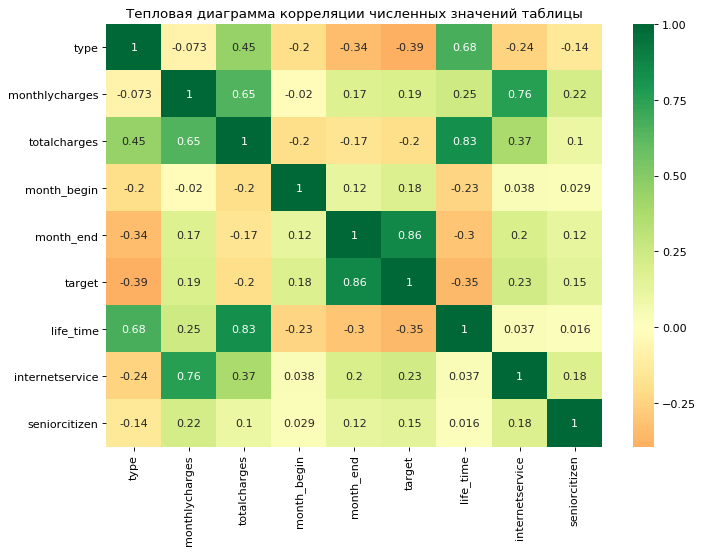

In [273]:
plt.figure(figsize=(10,7), dpi= 80);
sns.heatmap(
    df.corr(),
    xticklabels=df.corr().columns,
    yticklabels=df.corr().columns,
    cmap='RdYlGn', center=0, annot=True);
plt.title('Тепловая диаграмма корреляции численных значений таблицы');

In [70]:
# Зависимость пола на расторжение договора

In [71]:
sns.histplot(data = df, x='gender', stat='density', hue='target');

AttributeError: module 'seaborn' has no attribute 'histplot'

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>эх, библитеки... Прогонять графики дальше не буду - чтобы видеть их)

Мужчины и женщины практически одинаково заключают и расторгают договор, данный признак исключим из итогового датасета.

In [1614]:
# Зависимость возрастной группы на расторжение договора

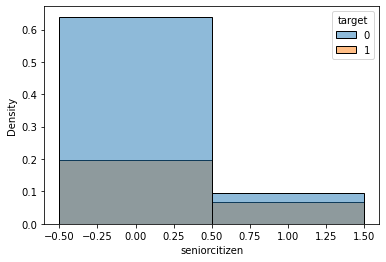

In [1615]:
sns.histplot(data = df, x='seniorcitizen', stat='density', hue='target', discrete=True);

Абонентов пожилого возраста гораздо меньше более молодого поколения, но данная группа абонентов более лояльна.

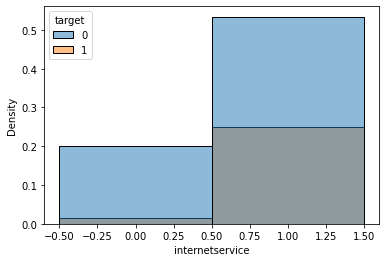

In [1616]:
sns.histplot(data = df, x='internetservice', stat='density', hue='target', discrete=True);

В какие месяцы расторгали договор.

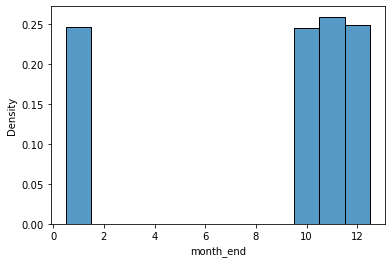

In [1617]:
sns.histplot(data = df[df['month_end'] > 0], x='month_end', stat='density', discrete=True);

Договора расторгали в январе, октябре, ноябре и декабре. Скидки, новые предложения от конкурентов, более выгодные тарифы можно рассматривать как возможные причины.

Распределение целевого признака:

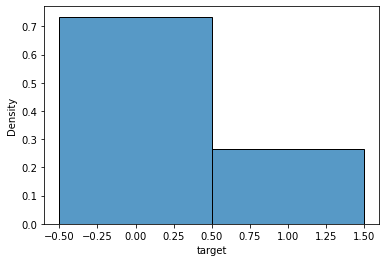

In [1618]:
sns.histplot(data = df, x='target', stat='density', discrete=True);

Присутствует дисбаланс классов, учтем эту информацию при обучении.

Как влияет признак партнера на расторжение договора:

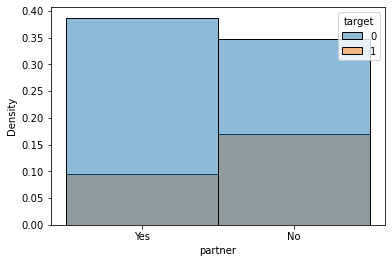

In [1619]:
sns.histplot(data = df, x='partner', stat='density', hue='target', discrete=True);

Парнеты более лояльны к оператору. Партнеры являются стабильной составляющей для компании, их больше чем абонентов пришедших из других каналов привлечения, и они реже расторгают договор.

Как влияет признак dependents на расторжение договора:

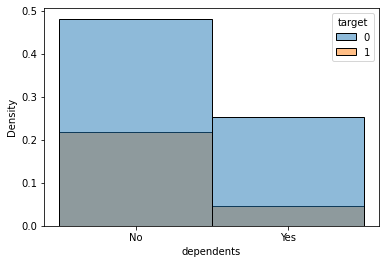

In [1620]:
sns.histplot(data = df, x='dependents', stat='density', hue='target', discrete=True);

Некоторая категория иждевенцев или госслужащих, не является многочисленной, но так же крайне лояльна к оператору связи.

In [274]:
for col in ['partner', 'dependents']:
    df[col] = df[col].apply(lambda x: 1 if x=='Yes' else 0)

Удалим признаки о которых говорилось ранее

In [275]:
df.drop(columns=['month_end', 'month_begin', 'gender', 'totalcharges'], inplace=True)

## Итог анализа данных

Данные подготовлены, не влияющие признаки, либо наоборот сильно коррелирующие признаки были исключены. Было удалено всего 11 абонентов подключившихся в феврале 2020 года.

# Обучение моделей

## Деление на выборки

In [276]:
features = df.drop(columns='target')
target = df['target']

features

,type,monthlycharges,life_time,internetservice,seniorcitizen,partner,dependents
0,1,29.85,31,1,0,1,0
1,12,56.95,1036,1,0,0,0
2,1,53.85,61,1,0,0,0
3,12,42.30,1371,1,0,0,0
4,1,70.70,61,1,0,0,0
...,...,...,...,...,...,...,...
7027,12,84.80,730,1,0,1,1
7028,12,103.20,2191,1,0,1,1
7029,1,29.60,337,1,0,1,1
7030,1,74.40,123,1,1,1,0


In [277]:
features_train, features_valid_test, target_train, target_valid_test = \
train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target) 

features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test)

In [278]:
numeric = ['monthlycharges', 'life_time']  
sc = StandardScaler()
sc.fit(features_train[numeric])
features_train[numeric] = sc.transform(features_train[numeric])
features_valid[numeric] = sc.transform(features_valid[numeric])

На выходе 3 выборки для обучения, оценки и тестирования модели. Численные признаки отмасштабировали. Можно переходить к обучению.

## Подбор моделей

### LogisticRegression

In [279]:
lr = LogisticRegression(random_state=12345, 
                           solver='liblinear',
                           class_weight='balanced'
                          )
lr.fit(features_train, target_train)
predicted_valid = lr.predict(features_valid)
print(f'Значение accuracy = {accuracy_score(target_valid, predicted_valid)} Значение f1_score = {f1_score(target_valid, predicted_valid)}')

Значение accuracy = 0.7446657183499289 Значение f1_score = 0.6279792746113989


In [280]:
probabilities_valid = lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('auc_roc =', roc_auc_score(target_valid, probabilities_one_valid))

auc_roc = 0.8367338743108237


In [281]:
pivot_val = pd.DataFrame({'LogisticRegression': [roc_auc_score(target_valid, probabilities_one_valid),
                                             accuracy_score(target_valid, predicted_valid), 
                                             f1_score(target_valid, predicted_valid)]}, 
                     index=['roc_auc_val', 'accuracy_val', 'f1_score_val'])

### DTC

In [282]:
parametrs = {'max_depth': range(5, 18, 2)}

dtc = GridSearchCV(DecisionTreeClassifier(random_state=12345, class_weight='balanced'),
                              parametrs, cv=5, scoring='f1') #roc_auc
dtc.fit(features_train, target_train)

depth = dtc.best_params_['max_depth']

predicted_valid = dtc.predict(features_valid)
print(f'Гиперпараметры для лучшей модели: Глубина леса = {depth}, Значение accuracy = {accuracy_score(target_valid, predicted_valid)} Значение f1_score = {f1_score(target_valid, predicted_valid)}')

probabilities_valid = dtc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('auc_roc =', roc_auc_score(target_valid, probabilities_one_valid))

Гиперпараметры для лучшей модели: Глубина леса = 9, Значение accuracy = 0.7603129445234709 Значение f1_score = 0.6284454244762955
auc_roc = 0.8097549537785516


In [283]:
pivot_val['DecisionTreeClassifier'] = [roc_auc_score(target_valid, probabilities_one_valid),
                                             accuracy_score(target_valid, predicted_valid), 
                                             f1_score(target_valid, predicted_valid)]

### RFC

In [284]:
parametrs = {'max_depth': range(5, 18, 2),
             'n_estimators': range(100, 300, 50)}

rfc = GridSearchCV(RandomForestClassifier(random_state=12345, class_weight='balanced'),
                              parametrs, cv=5, scoring ='f1') #roc_auc
rfc.fit(features_train, target_train)

depth = rfc.best_params_['max_depth']
esti = rfc.best_params_['n_estimators']

predicted_valid = rfc.predict(features_valid)
print(f'Гиперпараметры для лучшей модели: Количество деревьев = {esti}, Глубина леса = {depth}, Значение accuracy = {accuracy_score(target_valid, predicted_valid)} Значение f1_score = {f1_score(target_valid, predicted_valid)}')

probabilities_valid = rfc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('auc_roc =', roc_auc_score(target_valid, probabilities_one_valid))

Гиперпараметры для лучшей модели: Количество деревьев = 200, Глубина леса = 9, Значение accuracy = 0.7887624466571835 Значение f1_score = 0.6501766784452296
auc_roc = 0.8577213655018032


#### Важность признаков

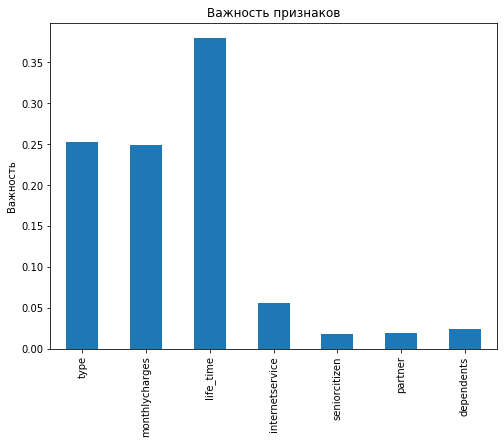

In [285]:
r_f_c = RandomForestClassifier(random_state=12345, class_weight='balanced', max_depth=depth, n_estimators=esti)
r_f_c.fit(features_train, target_train)


rfc_imp = pd.Series(r_f_c.feature_importances_,
                         features_train.columns)

fig, ax = plt.subplots(figsize=(8,6))
rfc_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
plt.show()

Life_time один из важнейших признаков для обучения модели

In [286]:
pivot_val['RandomForestClassifier'] = [roc_auc_score(target_valid, probabilities_one_valid),
                                             accuracy_score(target_valid, predicted_valid), 
                                             f1_score(target_valid, predicted_valid)]

In [287]:
pivot_val

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier
roc_auc_val,0.836734,0.809755,0.857721
accuracy_val,0.744666,0.760313,0.788762
f1_score_val,0.627979,0.628445,0.650177


### CatBoost

In [288]:
classes = np.unique(target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)
class_weights = dict(zip(classes, weights))

cbc = CatBoostClassifier(loss_function='Logloss',
                           verbose=0,
                           learning_rate=0.2,
                           iterations=300,
                           class_weights=weights,
                           random_state=12345)
cbc.fit(features_train, target_train)

predicted_valid = cbc.predict(features_valid)
print(f'Значение accuracy = {accuracy_score(target_valid, predicted_valid)} Значение f1_score = {f1_score(target_valid, predicted_valid)}')

probabilities_valid = cbc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('auc_roc =', roc_auc_score(target_valid, probabilities_one_valid))

Значение accuracy = 0.8591749644381224 Значение f1_score = 0.7461538461538462
auc_roc = 0.9158932864900717


In [289]:
pivot_val['CatBoostClassifier'] = [roc_auc_score(target_valid, probabilities_one_valid),
                                             accuracy_score(target_valid, predicted_valid), 
                                             f1_score(target_valid, predicted_valid)]

#### Важность признаков

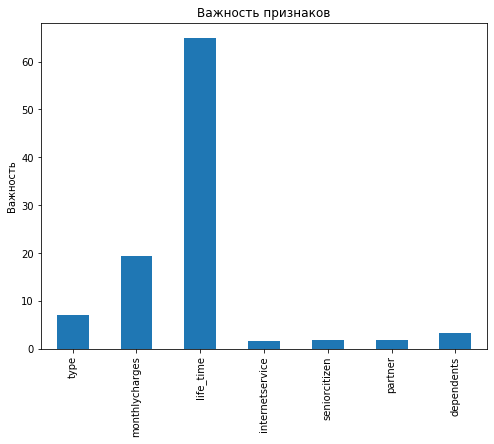

In [290]:
cbc_imp = pd.Series(cbc.feature_importances_,
                         features_train.columns)

fig, ax = plt.subplots(figsize=(8,6))
cbc_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
plt.show()

Насколько сильно меняется важность признаков в зависимости от алгоритмов модели.

### Итог

По итогу обучения получили хорошие показатели метрик, возможно из-за начальной предобработки. Оценим метрики на тестовой выборке.

# Тестирование моделей

In [291]:
features_test[numeric] = sc.transform(features_test[numeric])

LogisticRegression

In [292]:
predicted_test = lr.predict(features_test)
print(f'Значение accuracy = {accuracy_score(target_test, predicted_test)} Значение f1_score = {f1_score(target_test, predicted_test)}')

probabilities_test = lr.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('auc_roc =', roc_auc_score(target_test, probabilities_one_test))

Значение accuracy = 0.7277896233120114 Значение f1_score = 0.6119554204660588
auc_roc = 0.8259146041590093


In [293]:
pivot_test = pd.DataFrame({'LogisticRegression': [roc_auc_score(target_test, probabilities_one_test),
                                             accuracy_score(target_test, predicted_test), 
                                             f1_score(target_test, predicted_test)]}, 
                     index=['roc_auc_test', 'accuracy_test', 'f1_score_test'])

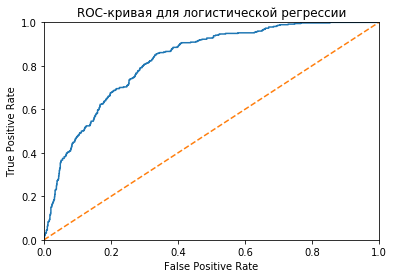

In [294]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# ROC-кривая обученной модели 
plt.plot(fpr, tpr, linestyle='-')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

# Оформление
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для логистической регрессии")

plt.show()

DecisionTreeClassifier

In [295]:
predicted_test = dtc.predict(features_test)
print(f'Значение accuracy = {accuracy_score(target_test, predicted_test)} Значение f1_score = {f1_score(target_test, predicted_test)}')

probabilities_test = dtc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('auc_roc =', roc_auc_score(target_test, probabilities_one_test))

Значение accuracy = 0.744136460554371 Значение f1_score = 0.6186440677966102
auc_roc = 0.8090280114509942


In [296]:
pivot_test['DecisionTreeClassifier'] = [roc_auc_score(target_test, probabilities_one_test),
                                             accuracy_score(target_test, predicted_test), 
                                             f1_score(target_test, predicted_test)]

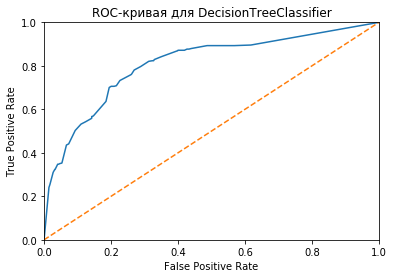

In [297]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# ROC-кривая обученной модели 
plt.plot(fpr, tpr, linestyle='-')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

# Оформление
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для DecisionTreeClassifier")

plt.show()

RandomForestClassifier

In [298]:
predicted_test = rfc.predict(features_test)
print(f'Значение accuracy = {accuracy_score(target_test, predicted_test)} Значение f1_score = {f1_score(target_test, predicted_test)}')

probabilities_test = rfc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('auc_roc =', roc_auc_score(target_test, probabilities_one_test))

Значение accuracy = 0.7668798862828714 Значение f1_score = 0.6247139588100687
auc_roc = 0.852084422610019


In [299]:
pivot_test['RandomForestClassifier'] = [roc_auc_score(target_test, probabilities_one_test),
                                             accuracy_score(target_test, predicted_test), 
                                             f1_score(target_test, predicted_test)]

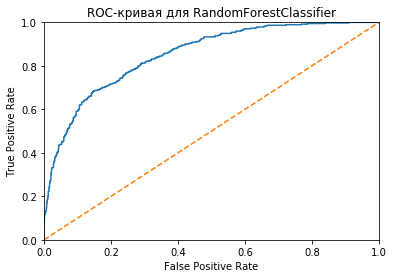

In [300]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# ROC-кривая обученной модели 
plt.plot(fpr, tpr, linestyle='-')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

# Оформление
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для RandomForestClassifier")

plt.show()

CatBoostClassifier

In [301]:
predicted_test = cbc.predict(features_test)
print(f'Значение accuracy = {accuracy_score(target_test, predicted_test)} Значение f1_score = {f1_score(target_test, predicted_test)}')

probabilities_test = cbc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('auc_roc =', roc_auc_score(target_test, probabilities_one_test))

Значение accuracy = 0.8450604122245914 Значение f1_score = 0.7261306532663316
auc_roc = 0.912419566083936


In [302]:
pivot_test['CatBoostClassifier'] = [roc_auc_score(target_test, probabilities_one_test),
                                             accuracy_score(target_test, predicted_test), 
                                             f1_score(target_test, predicted_test)]

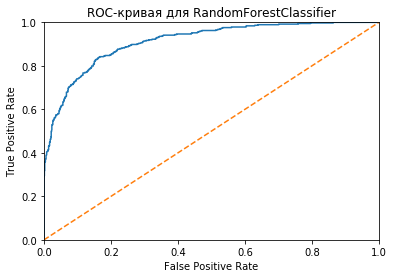

In [303]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# ROC-кривая обученной модели 
plt.plot(fpr, tpr, linestyle='-')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

# Оформление
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для RandomForestClassifier")

plt.show()

## Сравнение показателей метрик

In [304]:
pd.concat([pivot_val, pivot_test],sort=True).reindex(index=['roc_auc_val', 'roc_auc_test',
                                                            'accuracy_val', 'accuracy_test', 
                                                            'f1_score_val', 'f1_score_test'])

,CatBoostClassifier,DecisionTreeClassifier,LogisticRegression,RandomForestClassifier
roc_auc_val,0.915893,0.809755,0.836734,0.857721
roc_auc_test,0.912420,0.809028,0.825915,0.852084
accuracy_val,0.859175,0.760313,0.744666,0.788762
accuracy_test,0.845060,0.744136,0.727790,0.766880
f1_score_val,0.746154,0.628445,0.627979,0.650177
f1_score_test,0.726131,0.618644,0.611955,0.624714


# Общий вывод

В результате проекта классификации по прогназированию оттока клиентов из телеком компании:
+ Проведен предобработка и анализ данных
+ Обучены классические модели + CatBoost
+ Протестированы на тестовой выборке

Высокие показатели получились из-за адаптированного датасета (в основном однородные абоненты) + предобработка данных.

Лучше всего себя показала модель CatBoostClassifier.

# Отчёт по решению

<font color='black'> 
    <b><u>Выполнение пунктов плана:</u></b>
</font>
<font color='black'><br>


 - [x] Исследовательский анализ данных исходных таблиц (обработка пропусков)
 - [x] Анализ абонентов интернета и телефонии (возможное разбиение на кагорты, как признак для обучения)
 - [x] Слияние таблиц в итоговую
 - [x] Анализ итоговой таблицы, влияние признаков друг на друга, распределения, корреляция, утечка
 - [x] Разделение итоговой таблицы на тестовую, валидационную и тестовую выборки
 - [x] Обучение классических моделей + CatBoost, оценка метрик на валидационной выборке
 - [x] Тестирование обученных моделей, оценка метрик на тестовой выборке
 - [x] Вывод по итогу проекта, выбор оптимальной модели. 

<font color='black'> 
    <b><u>Какие трудности возникли и как вы их преодолели?</u></b>
</font>
<font color='black'><br>

Основная трудность - смотреть шире. Основная трудность была в утечке, метрики (в анализ брал необходимую roc_auc, так же accuracy и f1) достигали 0.99. То что месяц окончания договора (их всего 4) просто указывает на уход абонента напрямую, можно было и модели не строить. После общения с ревьюером, удален и начальный месяц (брал его в расчет из-за возможных маркетинговых акций по привлечению клиентов), т.к маркетинговой составляющей в задаче нет, удален и этот признак. После данных манипуляций, показатели метрик перешли в диапазон ожидаемых результатов.

Так же ревьюер поделился возможностью оценки важности признаков, что так же помогло в обнаружении аномальной работы модели из-за временнОй информации в признаках.

<font color='black'> 
    <b><u>Какие ключевые шаги в решении задачи выделили?</u></b>
</font>
<font color='black'><br>

 - [x] Исследовательский анализ данных исходных таблиц
 - [x] Поведенческий портрет абонента (итоговая таблица)
 - [x] Исследовательский анализ итоговой таблицы (распределения, корреляция, утечка)
 - [x] Обучение моделей
 - [x] Тестирование обученных моделей
 - [x] Сравнение метрик тестовой и валидационной выборки
 - [x] Вывод

<font color='black'> 
    <b><u>Какая ваша итоговая модель и какое у неё качество?</u></b>
</font>



CatBoostClassifier: roc_auc_validation =  0.915893, roc_auc_test = 0.912420 (сводная таблица п. 4.1)